# 02 LIANA tumor vs normal core atlas 
### Load DESEQ2 results to obtain significant interactions 

## 00. Libraries

In [5]:
import contextlib
import os

import decoupler as dc
import liana as li
import numpy as np
import pandas as pd
import sc_atlas_helpers as ah
import scanpy as sc
import scipy.sparse
import statsmodels.stats.multitest
from anndata import AnnData
from liana.method import (
    cellchat,
    cellphonedb,
    connectome,
    geometric_mean,
    logfc,
    natmi,
    singlecellsignalr,
)
from tqdm.auto import tqdm

## 01. Define variables, paths and comparison tumor vs normal

In [2]:
comparison = "tumor_normal"
subset = "core_atlas"
cell_type_oi = "Cancer cell"
n_top_ligands = 30

In [3]:
perturbation = comparison.split("_")[0].upper()
baseline = comparison.split("_")[1].upper()
title_plot = (
    f"{perturbation} vs {baseline}: {cell_type_oi}, top {n_top_ligands} DE ligands"
)
cell_type_oi = cell_type_oi.replace(" ", "")
save_name_plot = (
    f"{perturbation}_vs_{baseline}_{cell_type_oi}_top_{n_top_ligands}_DE_ligands"
)

In [6]:
dataDir = f"/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/h5ads/updated"
resDir = dataDir

In [7]:
resDir

'/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/h5ads/updated'

## 03. Functions

In [35]:
def fdr_correction(df, pvalue_col="pvalue", *, key_added="fdr", inplace=False):
    """Adjust p-values in a data frame with test results using FDR correction."""
    if not inplace:
        df = df.copy()

    df[key_added] = statsmodels.stats.multitest.fdrcorrection(df[pvalue_col].values)[1]

    if not inplace:
        return df

In [36]:
"""Plotting functions for group comparisons"""

import altair as alt
import numpy as np
import pandas as pd


def plot_lm_result_altair(
    df,
    p_cutoff=0.1,
    p_col="fdr",
    x="variable",
    y="group",
    color="coef",
    title="heatmap",
    cluster=False,
    value_max=None,
    configure=lambda x: x.configure_mark(opacity=1),
    cmap="redblue",
    reverse=True,
    domain=lambda x: [-x, x],
    order=None,
):
    """
    Plot a results data frame of a comparison as a heatmap
    """
    df_filtered = df.loc[lambda _: _[p_col] < p_cutoff, :]
    df_subset = df.loc[
        lambda _: _[x].isin(df_filtered[x].unique()) & _[y].isin(df[y].unique())
    ]
    if not df_subset.shape[0]:
        print("No values to plot")
        return

    if order is None:
        order = "ascending"
        if cluster:
            from scipy.cluster.hierarchy import leaves_list, linkage

            values_df = df_subset.pivot(index=y, columns=x, values=color)
            order = values_df.columns.values[
                leaves_list(
                    linkage(values_df.values.T, method="average", metric="euclidean")
                )
            ]

    def _get_significance(fdr):
        if fdr < 0.001:
            return "< 0.001"
        elif fdr < 0.01:
            return "< 0.01"
        elif fdr < 0.1:
            return "< 0.1"
        else:
            return np.nan

    df_subset["FDR"] = pd.Categorical([_get_significance(x) for x in df_subset[p_col]])

    if value_max is None:
        value_max = max(
            abs(np.nanmin(df_subset[color])), abs(np.nanmax(df_subset[color]))
        )
    # just setting the domain in altair will lead to "black" fields. Therefore, we constrain the values themselves.
    df_subset[color] = np.clip(df_subset[color], *domain(value_max))
    return configure(
        alt.Chart(df_subset, title=title)
        .mark_rect()
        .encode(
            x=alt.X(x, sort=order),
            y=y,
            color=alt.Color(
                color,
                scale=alt.Scale(scheme=cmap, reverse=reverse, domain=domain(value_max)),
            ),
        )
        + alt.Chart(df_subset.loc[lambda x: ~x["FDR"].isnull()])
        .mark_point(color="white", filled=True, stroke="black", strokeWidth=0)
        .encode(
            x=alt.X(x, sort=order),
            y=y,
            size=alt.Size(
                "FDR:N",
                scale=alt.Scale(
                    domain=["< 0.001", "< 0.01", "< 0.1"],
                    range=4 ** np.array([3, 2, 1]),
                ),
            ),
        )
    )

In [37]:
import warnings
from functools import reduce
from operator import and_
from typing import Sequence, Union

import numpy as np
import pandas as pd
from anndata import AnnData, ImplicitModificationWarning


def pseudobulk(
    adata,
    *,
    groupby: Union[str, Sequence[str]],
    aggr_fun=np.sum,
    min_obs=10,
) -> AnnData:
    """
    Calculate Pseudobulk of groups

    Parameters
    ----------
    adata
        annotated data matrix
    groupby
        One or multiple columns to group by
    aggr_fun
        Callback function to calculate pseudobulk. Must be a numpy ufunc supporting
        the `axis` attribute.
    min_obs
        Exclude groups with less than `min_obs` observations

    Returns
    -------
    New anndata object with same vars as input, but reduced number of obs.
    """
    if isinstance(groupby, str):
        groupby = [groupby]

    combinations = adata.obs.loc[:, groupby].drop_duplicates()

    if adata.is_view:
        # for whatever reason, the pseudobulk function is terribly slow when operating on a view.
        adata = adata.copy()

    # precompute masks
    masks = {}
    for col in groupby:
        masks[col] = {}
        for val in combinations[col].unique():
            masks[col][val] = adata.obs[col] == val

    expr_agg = []
    obs = []

    for comb in combinations.itertuples(index=False):
        mask = reduce(and_, (masks[col][val] for col, val in zip(groupby, comb)))
        if np.sum(mask) < min_obs:
            continue
        expr_row = aggr_fun(adata.X[mask, :], axis=0)
        obs_row = comb._asdict()
        obs_row["n_obs"] = np.sum(mask)
        # convert matrix to array if required (happens when aggregating spares matrix)
        try:
            expr_row = expr_row.A1
        except AttributeError:
            pass
        obs.append(obs_row)
        expr_agg.append(expr_row)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ImplicitModificationWarning)
        return AnnData(
            X=np.vstack(expr_agg),
            var=adata.var,
            obs=pd.DataFrame.from_records(obs),
        )

In [38]:
"""Helper functions for cellphonedb analysis

Focuses on differential cellphonedb analysis between conditions.
"""

from typing import List, Literal

import altair as alt

# from .pseudobulk import pseudobulk
import numpy as np
import pandas as pd
import scanpy as sc

# from .compare_groups.pl import plot_lm_result_altair
# from .util import fdr_correction


class CpdbAnalysis:
    def __init__(
        self, cpdb, adata, *, pseudobulk_group_by: List[str], cell_type_column: str
    ):
        """
        Class that handles comparative cellphonedb analysis.

        Parameters
        ----------
        cpdb
            pandas data frame with cellphonedb interactions.
            Required columns: `source_genesymbols`, `target_genesymbol`.
            You can get this from omnipathdb:
            https://omnipathdb.org/interactions/?fields=sources,references&genesymbols=1&databases=CellPhoneDB
        adata
            Anndata object with the target cells. Will use this to derive mean fraction of expressed cells.
            Should contain counts in X.
        pseudobulk_group_by
            See :func:`scanpy_helper.pseudobulk.pseudobulk`. Pseudobulk is used to compute the mean fraction
            of expressed cells by patient
        cell_type_column
            Column in anndata that contains the cell-type annotation.
        """
        self.cpdb = cpdb
        self.cell_type_column = cell_type_column
        self._find_expressed_genes(adata, pseudobulk_group_by)

    def _find_expressed_genes(self, adata, pseudobulk_group_by):
        """Compute the mean expression and fraction of expressed cells per cell-type.
        This is performed on the pseudobulk level, i..e. the mean of means per patient is calculated.
        """
        pb_fracs = pseudobulk(
            adata,
            groupby=pseudobulk_group_by + [self.cell_type_column],
            aggr_fun=lambda x, axis: np.sum(x > 0, axis) / x.shape[axis],  # type: ignore
        )
        fractions_expressed = pseudobulk(
            pb_fracs, groupby=self.cell_type_column, aggr_fun=np.mean
        )
        fractions_expressed.obs.set_index(self.cell_type_column, inplace=True)

        pb = pseudobulk(
            adata,
            groupby=pseudobulk_group_by + [self.cell_type_column],
        )
        sc.pp.normalize_total(pb, target_sum=1e6)
        sc.pp.log1p(pb)
        pb_mean_cell_type = pseudobulk(
            pb, groupby=self.cell_type_column, aggr_fun=np.mean
        )
        pb_mean_cell_type.obs.set_index(self.cell_type_column, inplace=True)

        self.expressed_genes = (
            fractions_expressed.to_df()
            .melt(ignore_index=False, value_name="fraction_expressed")
            .reset_index()
            .merge(
                pb_mean_cell_type.to_df()
                .melt(ignore_index=False, value_name="expr_mean")
                .reset_index(),
                on=[self.cell_type_column, "variable"],
            )
        )

    def significant_interactions(
        self,
        de_res: pd.DataFrame,
        *,
        pvalue_col="pvalue",
        fc_col="log2FoldChange",
        gene_symbol_col="gene_id",
        max_pvalue=0.1,
        min_abs_fc=1,
        adjust_fdr=True,
        min_frac_expressed=0.1,
        de_genes_mode: Literal["ligand", "receptor"] = "ligand",
    ) -> pd.DataFrame:
        """
        Generates a data frame of differentiall cellphonedb interactions.

        This function will extract all known ligands (or receptors, respectively) from a list of differentially expressed
        and find all receptors (or ligands, respectively) that are expressed above a certain cutoff in all cell-types.

        Parameters:
        -----------
        de_res
            List of differentially expressed genes
        pvalue_col
            column in de_res that contains the pvalue or false discovery rate
        gene_id_col
            column in de_res that contains the gene symbol
        min_frac_expressed
            Minimum fraction cells that need to express the receptor (or ligand) to be considered a potential interaction
        de_genes_mode
            If the list of de genes provided are ligands (default) or receptors. In case of `ligand`, cell-types
            that express corresonding receptors above the threshold will be identified. In case of `receptor`,
            cell-types that express corresponding ligands above the threshold will be identified.
        adjust_fdr
            If True, calculate false discovery rate on the pvalue, after filtering for genes that are contained
            in the cellphonedb.
        """
        if de_genes_mode == "ligand":
            cpdb_de_col = "source_genesymbol"
            cpdb_expr_col = "target_genesymbol"
        elif de_genes_mode == "receptor":
            cpdb_de_col = "target_genesymbol"
            cpdb_expr_col = "source_genesymbol"
        else:
            raise ValueError("Invalud value for de_genes_mode!")

        de_res = de_res.loc[lambda x: x[gene_symbol_col].isin(self.cpdb[cpdb_de_col])]
        if adjust_fdr:
            de_res = fdr_correction(de_res, pvalue_col=pvalue_col, key_added="fdr")
            pvalue_col = "fdr"

        significant_genes = de_res.loc[
            lambda x: (x[pvalue_col] < max_pvalue) & (np.abs(x[fc_col]) >= min_abs_fc),
            gene_symbol_col,
        ].unique()  # type: ignore
        significant_interactions = self.cpdb.loc[
            lambda x: x[cpdb_de_col].isin(significant_genes)
        ]

        res_df = (
            self.expressed_genes.loc[
                lambda x: x["fraction_expressed"] >= min_frac_expressed
            ]  # type: ignore
            .merge(
                significant_interactions,
                left_on="variable",
                right_on=cpdb_expr_col,
            )
            .drop(columns=["variable"])
            .merge(de_res, left_on=cpdb_de_col, right_on=gene_symbol_col)
            .drop(columns=[gene_symbol_col])
        )

        return res_df

    def plot_result(
        self,
        cpdb_res,
        *,
        pvalue_col="fdr",
        group_col="group",
        fc_col="log2FoldChange",
        title="CPDB analysis",
        aggregate=True,
        clip_fc_at=(-5, 5),
        label_limit=100,
        cluster: Literal["heatmap", "dotplot"] = "dotplot",
        de_genes_mode: Literal["ligand", "receptor"] = "ligand",
    ):
        """
        Plot cpdb results as heatmap

        Parameters
        ----------
        cpdb_res
            result of `significant_interactions`. May be further filtered or modified.
        group_col
            column to be used for the y axis of the heatmap
        aggregate
            whether to merge multiple targets of the same ligand into a single column
        de_genes_mode
            If the list of de genes provided are ligands (default) or receptors. If receptor, will show the dotplot
            at the top (source are expressed ligands) and the de heatmap at the bottom (target are the DE receptors).
            Otherwise the other way round.
        """
        if de_genes_mode == "ligand":
            cpdb_de_col = "source_genesymbol"
            cpdb_expr_col = "target_genesymbol"
        elif de_genes_mode == "receptor":
            cpdb_de_col = "target_genesymbol"
            cpdb_expr_col = "source_genesymbol"
        else:
            raise ValueError("Invalud value for de_genes_mode!")

        cpdb_res[fc_col] = np.clip(cpdb_res[fc_col], *clip_fc_at)

        # aggregate if there are multiple receptors per ligand
        if aggregate:
            cpdb_res = (
                cpdb_res.groupby(
                    [
                        self.cell_type_column,
                        cpdb_de_col,
                        fc_col,
                        pvalue_col,
                        group_col,
                    ]
                )
                .agg(
                    n=(cpdb_expr_col, len),
                    fraction_expressed=("fraction_expressed", np.max),
                    expr_mean=("expr_mean", np.max),
                )
                .reset_index()
                .merge(
                    cpdb_res.groupby(cpdb_de_col).agg(
                        **{
                            cpdb_expr_col: (
                                cpdb_expr_col,
                                lambda x: "|".join(np.unique(x)),
                            )
                        }
                    ),
                    on=cpdb_de_col,
                )
            )

        cpdb_res["interaction"] = [
            f"{s}_{t}" for s, t in zip(cpdb_res[cpdb_de_col], cpdb_res[cpdb_expr_col])
        ]

        # cluster heatmap
        if cluster is not None:
            from scipy.cluster.hierarchy import leaves_list, linkage

            _idx = self.cell_type_column if cluster == "dotplot" else group_col
            _values = "fraction_expressed" if cluster == "dotplot" else fc_col
            _columns = "interaction"
            values_df = (
                cpdb_res.loc[:, [_idx, _values, _columns]]
                .drop_duplicates()
                .pivot(
                    index=_idx,
                    columns=_columns,
                    values=_values,
                )
                .fillna(0)
            )
            order = values_df.columns.values[
                leaves_list(
                    linkage(values_df.values.T, method="average", metric="euclidean")
                )
            ]
        else:
            order = "ascending"

        p1 = plot_lm_result_altair(
            cpdb_res,
            color=fc_col,
            p_col=pvalue_col,
            x="interaction",
            configure=lambda x: x,
            title="",
            order=order,
            p_cutoff=1,
        ).encode(
            x=alt.X(
                title=None,
                axis=alt.Axis(
                    labelExpr="split(datum.label, '_')[0]",
                    orient="top" if de_genes_mode == "receptor" else "bottom",
                ),
            )
        )

        p2 = (
            alt.Chart(cpdb_res)
            .mark_circle()
            .encode(
                x=alt.X(
                    "interaction",
                    axis=alt.Axis(
                        grid=True,
                        orient="bottom" if de_genes_mode == "receptor" else "top",
                        title=None,
                        labelExpr="split(datum.label, '_')[1]",
                        labelLimit=label_limit,
                    ),
                    sort=order,
                ),
                y=alt.Y(self.cell_type_column, axis=alt.Axis(grid=True), title=None),
                size=alt.Size("fraction_expressed"),
                color=alt.Color("expr_mean", scale=alt.Scale(scheme="cividis")),
            )
        )

        if de_genes_mode == "receptor":
            p1, p2 = p2, p1

        return (
            alt.vconcat(p1, p2, title=title)
            .resolve_scale(size="independent", color="independent", x="independent")
            .configure_mark(opacity=1)
            .configure_concat(spacing=label_limit - 130)
        )

## 04. Load adata with LIANA ranked information 

In [12]:
adata = sc.read_h5ad(f"{dataDir}/adata_rank_agregate.h5ad")

In [14]:
adata.obs["cell_type_fine"].replace(
    {
        "Cancer_BEST4": "Cancer cell",
        "Cancer_Colonocyte_like": "Cancer cell",
        "Cancer_Crypt_like": "Cancer cell",
        "Cancer_Goblet_like": "Cancer cell",
        "Cancer_TA_like": "Cancer cell",
    },
    inplace=True,
)

In [8]:
dataDir

'/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/h5ads/updated'

In [9]:
adata

AnnData object with n_obs × n_vars = 2332515 × 28476
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'ethnicity', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 'reference_genome', 'matrix_type', 'enr

In [ ]:
set(adata.obs.cell_type_fine)

In [12]:
adata.obs["cell_type_fine"].replace(
    {
        "Cancer BEST4": "Cancer cell",
        "Cancer Colonocyte-like": "Cancer cell",
        "Cancer Crypt-like": "Cancer cell",
        "Cancer Goblet-like": "Cancer cell",
        "Cancer TA-like": "Cancer cell",
    },
    inplace=True,
)

## 04.1. Load deseq results latest final atlas

In [2]:
# import glob
# import os
#
# import pandas as pd
#
## Define the path to your folder (update this to the correct folder path)
# folder_path = "/data/projects/2022/CRCA/results/v1/downstream_analyses/de_analysis/de_analysis_paired_tumor_normal/deseq2_dgea/"
#
## Define the pattern to match files with "-DESeq2_result.tsv" suffix
# file_pattern = os.path.join(folder_path, "*-DESeq2_result.tsv")
#
## List all matching files
# file_paths = glob.glob(file_pattern)
#
## Initialize an empty list to store dataframes
# dataframes = []
#
## Iterate over each file
# for file_path in file_paths:
#    # Extract the cell type from the file name
#    cell_type = os.path.basename(file_path).split("-DESeq2_result.tsv")[0]
#
#    # Read the file into a DataFrame
#    df = pd.read_csv(file_path, sep="\t")
#
#    # Add the cell_type column
#    df["cell_type"] = cell_type
#
#    # Append the DataFrame to the list
#    dataframes.append(df)
#
## Concatenate all dataframes into a single dataframe
# combined_df = pd.concat(dataframes, ignore_index=True)
#
## Save the combined DataFrame to a new TSV file
# output_file = os.path.join("combined_DESeq2_results.tsv")
# combined_df.to_csv(output_file, sep="\t", index=False)

# print(f"Combined file saved to {output_file}")

Combined file saved to combined_DESeq2_results.tsv


In [15]:
de_res = pd.read_csv("combined_DESeq2_results.tsv", sep="\t")

In [16]:
de_res["cell_type"] = de_res["cell_type"].str.replace("_", " ")

In [17]:
de_res = de_res.rename(columns={"symbol": "gene_id"})

In [18]:
de_res = de_res.rename(columns={"cell_type": "cell_type_fine"})

In [19]:
de_res

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison,cell_type_fine
0,COL4A1,350.801173,2.420962,0.114288,21.182980,1.370808e-99,2.686775e-95,0.542298,tumor_vs_normal,Pericyte
1,SPARC,772.587665,1.751049,0.082878,21.128098,4.388731e-99,4.202095e-95,0.555054,tumor_vs_normal,Pericyte
2,COL4A2,288.448189,1.831955,0.087302,20.984143,9.155939e-98,5.981859e-94,0.542298,tumor_vs_normal,Pericyte
3,CYTOR,102.947437,2.524187,0.123917,20.370013,3.085937e-92,1.491521e-88,0.549781,tumor_vs_normal,Pericyte
4,COL18A1,219.802384,1.413092,0.074889,18.869076,2.048508e-79,5.816379e-76,0.748699,tumor_vs_normal,Pericyte
...,...,...,...,...,...,...,...,...,...,...
296939,FCGR2B,10.473368,0.000085,0.095667,0.000890,9.992899e-01,9.491277e-01,1.498430,tumor_vs_normal,B cell naive
296940,COMMD9,3.437405,-0.000117,0.140199,-0.000832,9.993365e-01,1.000000e+00,0.734389,tumor_vs_normal,B cell naive
296941,CREB3L2,4.089512,0.000086,0.142866,0.000605,9.995171e-01,1.000000e+00,0.927970,tumor_vs_normal,B cell naive
296942,SAP30BP,7.734365,0.000051,0.097512,0.000522,9.995835e-01,1.000000e+00,0.498537,tumor_vs_normal,B cell naive


In [21]:
de_res.rename(columns={"symbol": "gene_id"}, inplace=True)

In [22]:
de_res["cell_type_fine"].replace(
    {
        "Cancer_BEST4": "Cancer cell",
        "Cancer_Colonocyte_like": "Cancer cell",
        "Cancer_Crypt_like": "Cancer cell",
        "Cancer_Goblet_like": "Cancer cell",
        "Cancer_TA_like": "Cancer cell",
    },
    inplace=True,
)

In [23]:
adata.obs["cell_type_fine"] = adata.obs["cell_type_fine"].str.replace("-", " ")

In [25]:
de_res["cell_type_fine"] = de_res["cell_type_fine"].str.replace("_", " ")

In [28]:
de_res["cell_type_fine"].replace(
    {
        "Monocyte non classical": "Monocyte",
        "Monocyte classical": "Monocyte",
    },
    inplace=True,
)

## 05. Load DESEQ2 results

In [ ]:
# DESEQ2 output path
# deseq2_path_prefix = "/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/core_atlas/tumor_normal/epithelial_cancer/03_deseq2/"

In [ ]:
# file_name_deseq2_out = "Cancer_Epithelial_tumor_vs_normal_DESeq2_result.tsv"

In [ ]:
# de_res = (
#    pd.read_csv(
#        f"{deseq2_path_prefix}/{file_name_deseq2_out}",
#        sep="\t",
#    )
#    .fillna(1)
#    .pipe(fdr_correction)
#    .rename(columns={"comparison": "group"})
# )

In [99]:
# del cpdba
# del cpdb_sig_int
# del cpdb_res

In [29]:
cpdb_res = adata.uns["rank_aggregate"].loc[lambda x: x["specificity_rank"] <= 0.01]

In [30]:
cpdb_res

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
5877,Neutrophil,B cell memory,CXCL8,CD79A,4.088645,0.0,16.581238,2.547096,3.210732,0.018446,0.954737,0.459930,0.0,0.000596,6.508019e-13
8892,Neutrophil,B cell naive,CXCL8,CD79A,4.016943,0.0,15.942067,2.501774,3.285903,0.017735,0.953880,0.466678,0.0,0.000724,6.333152e-12
4533,Fibroblast S1,B cell memory,CXCL14,CXCR4,3.881306,0.0,15.063982,2.401495,2.704146,0.012152,0.952618,0.443199,0.0,0.004435,1.235815e-10
256278,Fibroblast S1,NKT,CXCL14,CXCR4,3.927548,0.0,15.425118,2.424877,2.722303,0.012443,0.953150,0.442630,0.0,0.003978,1.237084e-10
7913,Fibroblast S1,B cell naive,CXCL14,CXCR4,3.874279,0.0,15.009102,2.397936,2.767746,0.012107,0.952536,0.448406,0.0,0.004518,1.581593e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263626,Endothelial venous,Neutrophil,CSF1,CSF3R,2.182809,0.0,1.711002,2.720755,2.921175,0.006615,0.871396,0.000000,1.0,0.002857,1.000000e+00
263632,Endothelial venous,Neutrophil,SELE,CEACAM1,0.988220,0.0,0.791274,2.101508,2.547931,0.022826,0.821679,0.000000,1.0,0.000392,1.000000e+00
318348,pDC,Treg,ICOSLG,CTLA4,1.577325,0.0,1.777491,1.654060,2.560671,0.019011,0.873517,0.000000,1.0,0.003747,1.000000e+00
263637,Endothelial venous,Neutrophil,VEGFC,FLT1,0.651545,0.0,0.387874,1.514106,2.188805,0.015146,0.763376,0.000000,1.0,0.009223,1.000000e+00


In [31]:
cpdb_res = cpdb_res.rename(
    columns={
        "ligand_complex": "source_genesymbol",
        "receptor_complex": "target_genesymbol",
    }
)

In [32]:
cpdba = CpdbAnalysis(
    cpdb_res,
    adata,
    pseudobulk_group_by=["patient_id"],
    cell_type_column="cell_type_fine",
)

# What is doing
# self.cpdb = cpdb
# self.cell_type_column = cell_type_column
# self._find_expressed_genes(adata, pseudobulk_group_by)

In [71]:
cpdba.expressed_genes

,cell_type_fine,variable,fraction_expressed,expr_mean
0,Cancer cell,ENSG00000238009,0.0,0.0
1,Colonocyte BEST4,ENSG00000238009,0.0,0.0
2,Mast cell,ENSG00000238009,0.0,0.0
3,TA progenitor,ENSG00000238009,0.0,0.0
4,Goblet,ENSG00000238009,0.0,0.0
...,...,...,...,...
415648,Endothelial venous,ENSG00000278817,0.0,0.0
415649,Pericyte,ENSG00000278817,0.0,0.0
415650,Monocyte,ENSG00000278817,0.0,0.0
415651,TAN1,ENSG00000278817,0.0,0.0


In [98]:
# cpdb_sig_int = cpdba.significant_interactions(
#   de_res, max_pvalue=0.1
# )

In [129]:
cpdb_de_col = "source_genesymbol"
cpdb_expr_col = "target_genesymbol"
de_genes_mode = "ligand"
pvalue_col = "pvalue"
fc_col = "log2FoldChange"
gene_symbol_col = "gene_id"
max_pvalue = 0.1
min_abs_fc = 1
adjust_fdr = True
min_frac_expressed = 0.1

In [130]:
de_res = de_res.loc[lambda x: x[gene_symbol_col].isin(cpdba.cpdb[cpdb_de_col])]

In [131]:
de_res

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison,cell_type_fine,fdr
0,COL4A1,350.801173,2.420962,0.114288,21.182980,1.370808e-99,2.686775e-95,0.542298,tumor_vs_normal,Pericyte,7.680250e-96
1,SPARC,772.587665,1.751049,0.082878,21.128098,4.388731e-99,4.202095e-95,0.555054,tumor_vs_normal,Pericyte,2.413347e-95
2,COL4A2,288.448189,1.831955,0.087302,20.984143,9.155939e-98,5.981859e-94,0.542298,tumor_vs_normal,Pericyte,4.687588e-94
4,COL18A1,219.802384,1.413092,0.074889,18.869076,2.048508e-79,5.816379e-76,0.748699,tumor_vs_normal,Pericyte,3.849951e-76
11,COL1A1,676.868441,2.184219,0.121995,17.904094,1.095630e-71,1.296187e-68,0.748699,tumor_vs_normal,Pericyte,1.311858e-68
...,...,...,...,...,...,...,...,...,...,...,...
295840,TFF3,4.864068,0.073701,0.231777,0.317980,7.504999e-01,1.000000e+00,0.498537,tumor_vs_normal,B cell naive,8.898481e-01
295969,PTPN6,26.416941,-0.019355,0.068392,-0.283005,7.771733e-01,8.229710e-01,1.686170,tumor_vs_normal,B cell naive,9.058780e-01
296343,CD24,18.283797,-0.012616,0.072576,-0.173831,8.619983e-01,8.488925e-01,1.686170,tumor_vs_normal,B cell naive,9.538555e-01
296413,MAML2,8.191253,0.015510,0.100001,0.155095,8.767462e-01,1.000000e+00,0.662206,tumor_vs_normal,B cell naive,9.614721e-01


In [132]:
if adjust_fdr:
    de_res = fdr_correction(de_res, pvalue_col=pvalue_col, key_added="fdr")
    pvalue_col = "fdr"

In [133]:
de_res

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison,cell_type_fine,fdr
0,COL4A1,350.801173,2.420962,0.114288,21.182980,1.370808e-99,2.686775e-95,0.542298,tumor_vs_normal,Pericyte,5.283486e-97
1,SPARC,772.587665,1.751049,0.082878,21.128098,4.388731e-99,4.202095e-95,0.555054,tumor_vs_normal,Pericyte,1.578773e-96
2,COL4A2,288.448189,1.831955,0.087302,20.984143,9.155939e-98,5.981859e-94,0.542298,tumor_vs_normal,Pericyte,3.087840e-95
4,COL18A1,219.802384,1.413092,0.074889,18.869076,2.048508e-79,5.816379e-76,0.748699,tumor_vs_normal,Pericyte,3.454297e-77
11,COL1A1,676.868441,2.184219,0.121995,17.904094,1.095630e-71,1.296187e-68,0.748699,tumor_vs_normal,Pericyte,1.343641e-69
...,...,...,...,...,...,...,...,...,...,...,...
295840,TFF3,4.864068,0.073701,0.231777,0.317980,7.504999e-01,1.000000e+00,0.498537,tumor_vs_normal,B cell naive,8.339574e-01
295969,PTPN6,26.416941,-0.019355,0.068392,-0.283005,7.771733e-01,8.229710e-01,1.686170,tumor_vs_normal,B cell naive,8.545439e-01
296343,CD24,18.283797,-0.012616,0.072576,-0.173831,8.619983e-01,8.488925e-01,1.686170,tumor_vs_normal,B cell naive,9.206933e-01
296413,MAML2,8.191253,0.015510,0.100001,0.155095,8.767462e-01,1.000000e+00,0.662206,tumor_vs_normal,B cell naive,9.294738e-01


In [134]:
significant_genes = de_res.loc[
    lambda x: (x[pvalue_col] < max_pvalue) & (np.abs(x[fc_col]) >= min_abs_fc),
    gene_symbol_col,
].unique()  # type: ignore

In [135]:
significant_genes

array(['COL4A1', 'SPARC', 'COL4A2', 'COL18A1', 'COL1A1', 'ANGPT2',
       'ANGPTL1', 'CXCL12', 'COL5A3', 'COL1A2', 'TNXB', 'COL5A2', 'THY1',
       'INHBA', 'PGF', 'BGN', 'AGRN', 'ITGAV', 'ADAM12', 'COL6A3',
       'COL12A1', 'EFEMP1', 'PDGFA', 'CSPG4', 'LAMB3', 'CP', 'CXCL8',
       'CCL2', 'PTN', 'F10', 'BMP5', 'EDIL3', 'CD34', 'FGFR4', 'COL3A1',
       'CADM3', 'HAPLN1', 'LPL', 'SFRP1', 'SEMA3E', 'COL13A1', 'FN1',
       'CX3CL1', 'COL4A5', 'ALCAM', 'WNT2B', 'DCN', 'THBS2', 'POSTN',
       'CTHRC1', 'SLIT2', 'BMP4', 'TNC', 'CCL8', 'APOE', 'NTRK3',
       'CXCL14', 'PLAU', 'WNT5A', 'NCAM1', 'JAM2', 'CXCL3', 'CCN4',
       'DLL1', 'FBLN1', 'CXCL2', 'LAMA2', 'SERPINE1', 'AGT', 'COL8A1',
       'SEMA3B', 'CCL11', 'CCL3', 'APOD', 'PDGFD', 'COL9A1', 'AFDN',
       'LAMA3', 'SEMA3D', 'PTGS2', 'LIF', 'IL33', 'PTPN6', 'SCT', 'CXCL9',
       'WNT4', 'SLITRK6', 'CCL13', 'MMRN2', 'TSLP', 'MFAP5', 'CCL20',
       'GUCA2A', 'MMP9', 'IL1B', 'CXCL10', 'SNCA', 'THBS4', 'S100A9',
       'RARRES2', 'C

In [136]:
significant_interactions = cpdba.cpdb.loc[
    lambda x: x[cpdb_de_col].isin(significant_genes)
]

In [137]:
significant_interactions

,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
5877,Neutrophil,B cell memory,CXCL8,CD79A,4.088645,0.0,16.581238,2.547096,3.210732,0.018446,0.954737,0.459930,0.0,0.000596,6.508019e-13
8892,Neutrophil,B cell naive,CXCL8,CD79A,4.016943,0.0,15.942067,2.501774,3.285903,0.017735,0.953880,0.466678,0.0,0.000724,6.333152e-12
4533,Fibroblast S1,B cell memory,CXCL14,CXCR4,3.881306,0.0,15.063982,2.401495,2.704146,0.012152,0.952618,0.443199,0.0,0.004435,1.235815e-10
256278,Fibroblast S1,NKT,CXCL14,CXCR4,3.927548,0.0,15.425118,2.424877,2.722303,0.012443,0.953150,0.442630,0.0,0.003978,1.237084e-10
7913,Fibroblast S1,B cell naive,CXCL14,CXCR4,3.874279,0.0,15.009102,2.397936,2.767746,0.012107,0.952536,0.448406,0.0,0.004518,1.581593e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263475,Endothelial lymphatic,Neutrophil,CCL14,CCR1,0.929852,0.0,0.638811,1.529113,2.645934,0.019877,0.805455,0.000000,1.0,0.008364,1.000000e+00
263580,Endothelial venous,Neutrophil,CCL23,FPR2,1.392314,0.0,0.982855,2.967226,3.346278,0.089105,0.837013,0.000000,1.0,0.000005,1.000000e+00
263626,Endothelial venous,Neutrophil,CSF1,CSF3R,2.182809,0.0,1.711002,2.720755,2.921175,0.006615,0.871396,0.000000,1.0,0.002857,1.000000e+00
263632,Endothelial venous,Neutrophil,SELE,CEACAM1,0.988220,0.0,0.791274,2.101508,2.547931,0.022826,0.821679,0.000000,1.0,0.000392,1.000000e+00


In [138]:
res_df = cpdba.expressed_genes.loc[
    lambda x: x["fraction_expressed"] >= min_frac_expressed
]

In [38]:
res_df

,cell_type_fine,variable,fraction_expressed,expr_mean
105,Cancer cell,ENSG00000230021,0.726579,4.215565
106,Colonocyte BEST4,ENSG00000230021,0.679173,4.352269
108,TA progenitor,ENSG00000230021,0.815340,4.309721
109,Goblet,ENSG00000230021,0.550208,4.186159
112,Colonocyte,ENSG00000230021,0.873708,4.569797
...,...,...,...,...
415565,Pericyte,ENSG00000273748,0.192360,3.063546
415568,Treg,ENSG00000273748,0.139294,3.360552
415591,Colonocyte BEST4,ENSG00000271254,0.169373,2.164212
415594,Goblet,ENSG00000271254,0.165841,2.046019


In [49]:
significant_interactions

,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
86395,Neutrophil,B cell,CXCL8,CD79A,3.073154,0.0,8.167760,3.120965,4.226542,0.200990,0.979009,0.219657,0.0,2.196817e-04,8.685382e-14
104971,Schwann cell,Macrophage,APP,CD74,3.144779,0.0,8.446178,3.132702,3.114603,0.027397,0.979351,0.216127,0.0,6.806544e-03,2.081437e-13
89022,Neutrophil,Plasma cell,CXCL8,CD79A,2.893516,0.0,6.657732,2.740749,4.003169,0.163831,0.976802,0.184005,0.0,4.393557e-04,8.923766e-12
77471,Monocyte,B cell,CXCL8,CD79A,2.481102,0.0,5.866662,2.727677,2.102214,0.144365,0.975325,0.171467,0.0,3.067861e-03,2.647376e-10
70567,Macrophage,Macrophage,HLA-DRA,CD4,2.524664,0.0,4.985256,3.894483,3.052600,0.048612,0.973289,0.144122,0.0,5.578882e-03,3.596025e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37214,Enteroendocrine,Schwann cell,TTR,NGFR,0.270197,0.0,0.059663,9.181740,0.525550,0.833837,0.799444,0.000000,1.0,6.523499e-07,1.000000e+00
37512,Enteroendocrine,Tuft,GAL,GRM7,0.206193,0.0,0.036212,3.891269,0.563501,0.364798,0.756423,0.000000,1.0,5.624397e-03,1.000000e+00
102752,Schwann cell,Enteroendocrine,PDGFB,ADGRV1,0.250861,0.0,0.026692,3.739591,0.423579,0.198508,0.727237,0.000000,1.0,7.053301e-03,1.000000e+00
102697,Schwann cell,Enteroendocrine,LGI4,ADAM22,0.886170,0.0,0.055070,7.399060,1.368363,0.063836,0.792945,0.000000,1.0,2.282842e-03,1.000000e+00


In [53]:
res_df = cpdba.expressed_genes.loc[
    lambda x: x["fraction_expressed"] >= min_frac_expressed
].merge(  # type: ignore
    significant_interactions,
    left_on="variable",
    right_on=cpdb_expr_col,
)

In [48]:
cpdb_expr_col

'target_genesymbol'

In [40]:
res_df

,cell_type_fine,variable,fraction_expressed,expr_mean,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
0,Cancer cell,EPHB2,0.741189,4.470367,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,7.934602,1.808524,0.165899,0.932572,0.023360,0.0,0.000058,0.001159
1,Cancer cell,EPHB2,0.741189,4.470367,Schwann cell,Epithelial progenitor,L1CAM,EPHB2,1.199925,0.0,0.652136,7.864748,1.782867,0.150625,0.929471,0.022004,0.0,0.000068,0.001473
2,Cancer cell,EPHB2,0.741189,4.470367,Schwann cell,Cancer cell,L1CAM,EPHB2,1.192190,0.0,0.619844,7.830644,1.835825,0.143166,0.927788,0.017392,0.0,0.000051,0.003412
3,Cancer cell,EPHB2,0.741189,4.470367,Schwann cell,Tuft,L1CAM,EPHB2,1.158540,0.0,0.479359,7.682237,1.774676,0.110718,0.918691,0.008420,0.0,0.000145,0.024920
4,Cancer cell,EPHB2,0.741189,4.470367,Schwann cell,Goblet,L1CAM,EPHB2,1.126360,0.0,0.345009,7.540321,1.676543,0.079687,0.905531,0.006008,0.0,0.000813,0.051496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8876,Fibroblast S3,GPC4,0.265459,3.814570,Pericyte,Schwann cell,COL18A1,GPC4,0.412504,0.0,0.143196,4.124221,0.694817,0.141106,0.860635,0.002007,0.0,0.004234,0.344805
8877,Crypt cell,GPC4,0.391947,3.025971,Schwann cell,Schwann cell,FGF2,GPC4,0.420807,0.0,0.147319,5.404935,0.713256,0.203485,0.862328,0.002311,0.0,0.001115,0.322427
8878,Crypt cell,GPC4,0.391947,3.025971,Pericyte,Schwann cell,COL18A1,GPC4,0.412504,0.0,0.143196,4.124221,0.694817,0.141106,0.860635,0.002007,0.0,0.004234,0.344805
8879,Pericyte,GPC4,0.257297,3.854441,Schwann cell,Schwann cell,FGF2,GPC4,0.420807,0.0,0.147319,5.404935,0.713256,0.203485,0.862328,0.002311,0.0,0.001115,0.322427


In [41]:
res_df = (
    cpdba.expressed_genes.loc[
        lambda x: x["fraction_expressed"] >= min_frac_expressed
    ]  # type: ignore
    .merge(
        significant_interactions,
        left_on="variable",
        right_on=cpdb_expr_col,
    )
    .drop(columns=["variable"])
)

In [42]:
res_df

,cell_type_fine,fraction_expressed,expr_mean,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
0,Cancer cell,0.741189,4.470367,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,7.934602,1.808524,0.165899,0.932572,0.023360,0.0,0.000058,0.001159
1,Cancer cell,0.741189,4.470367,Schwann cell,Epithelial progenitor,L1CAM,EPHB2,1.199925,0.0,0.652136,7.864748,1.782867,0.150625,0.929471,0.022004,0.0,0.000068,0.001473
2,Cancer cell,0.741189,4.470367,Schwann cell,Cancer cell,L1CAM,EPHB2,1.192190,0.0,0.619844,7.830644,1.835825,0.143166,0.927788,0.017392,0.0,0.000051,0.003412
3,Cancer cell,0.741189,4.470367,Schwann cell,Tuft,L1CAM,EPHB2,1.158540,0.0,0.479359,7.682237,1.774676,0.110718,0.918691,0.008420,0.0,0.000145,0.024920
4,Cancer cell,0.741189,4.470367,Schwann cell,Goblet,L1CAM,EPHB2,1.126360,0.0,0.345009,7.540321,1.676543,0.079687,0.905531,0.006008,0.0,0.000813,0.051496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8876,Fibroblast S3,0.265459,3.814570,Pericyte,Schwann cell,COL18A1,GPC4,0.412504,0.0,0.143196,4.124221,0.694817,0.141106,0.860635,0.002007,0.0,0.004234,0.344805
8877,Crypt cell,0.391947,3.025971,Schwann cell,Schwann cell,FGF2,GPC4,0.420807,0.0,0.147319,5.404935,0.713256,0.203485,0.862328,0.002311,0.0,0.001115,0.322427
8878,Crypt cell,0.391947,3.025971,Pericyte,Schwann cell,COL18A1,GPC4,0.412504,0.0,0.143196,4.124221,0.694817,0.141106,0.860635,0.002007,0.0,0.004234,0.344805
8879,Pericyte,0.257297,3.854441,Schwann cell,Schwann cell,FGF2,GPC4,0.420807,0.0,0.147319,5.404935,0.713256,0.203485,0.862328,0.002311,0.0,0.001115,0.322427


In [139]:
res_df = (
    cpdba.expressed_genes.loc[
        lambda x: x["fraction_expressed"] >= min_frac_expressed
    ]  # type: ignore
    .merge(
        significant_interactions,
        left_on="variable",
        right_on=cpdb_expr_col,
    )
    .drop(columns=["variable"])
    .merge(de_res, left_on=cpdb_de_col, right_on=gene_symbol_col)
)

In [102]:
res_df = (
    cpdba.expressed_genes.loc[
        lambda x: x["fraction_expressed"] >= min_frac_expressed
    ]  # type: ignore
    .merge(
        significant_interactions,
        left_on="variable",
        right_on=cpdb_expr_col,
    )
    .drop(columns=["variable"])
    .merge(de_res, left_on=cpdb_de_col, right_on=gene_symbol_col)
    .drop(columns=[gene_symbol_col])
)

In [141]:
res_df = res_df.drop(columns=["cell_type_fine_y"]).rename(columns={"cell_type_fine_x": "cell_type_fine"})


In [166]:
res_df.to_csv("res_df_lastest_25nov_grouped.csv")

In [210]:
res_df_ss.to_csv("res_df_ss_lastest_25nov_grouped_subset.csv")

In [200]:
res_df_ss.to_csv("res_df_ss_lastest_25nov_grouped.csv")

In [73]:
cpdb_de_col

'source_genesymbol'

In [194]:
res_df_ss = res_df

In [195]:
res_df_ss

,cell_type_fine,fraction_expressed,expr_mean,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,...,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison,fdr
0,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,2.100682,-0.251735,2.797514,-0.089985,9.282989e-01,9.818903e-01,1.000000,tumor_vs_normal,9.608864e-01
1,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,3.461028,1.141925,1.871984,0.610008,5.418564e-01,6.861301e-01,1.000000,tumor_vs_normal,6.566039e-01
2,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,69.956295,-0.863094,0.188350,-4.582395,4.596797e-06,1.595367e-04,1.271814,tumor_vs_normal,1.485696e-05
3,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,1.084218,-1.306785,1.071528,-1.219553,2.226345e-01,3.960291e-01,1.089391,tumor_vs_normal,3.169752e-01
4,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,1.536925,-0.888934,2.893996,-0.307165,7.587178e-01,8.112616e-01,1.000000,tumor_vs_normal,8.409341e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059490,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,13.010958,0.406310,0.200426,2.027232,4.263867e-02,2.106610e-01,0.728204,tumor_vs_normal,7.371940e-02
1059491,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,29.416788,-0.042485,0.078764,-0.539396,5.896138e-01,8.102904e-01,0.915114,tumor_vs_normal,7.003205e-01
1059492,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,40.106848,0.189417,0.140770,1.345574,1.784399e-01,5.960971e-01,1.000000,tumor_vs_normal,2.612212e-01
1059493,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,2.451596,-2.289989,0.371856,-6.158261,7.354820e-10,7.583222e-09,1.000000,tumor_vs_normal,3.487400e-09


In [201]:
set(res_df_ss.cell_type_fine)

{'B cell',
 'CD4',
 'CD8',
 'Cancer cell',
 'Colonocyte',
 'Crypt cell',
 'DC',
 'Endothelial',
 'Enteroendocrine',
 'Eosinophil',
 'Fibroblast',
 'Goblet',
 'ILC',
 'Macrophage',
 'Mast cell',
 'Monocyte',
 'NK',
 'Neutrophil',
 'Pericyte',
 'Plasma',
 'Schwann cell',
 'TA progenitor',
 'Treg',
 'Tuft',
 'gamma delta'}

In [192]:
res_df_ss

In [159]:
len(set(res_df.target))

28

In [196]:
res_df_ss["cell_type_fine"].replace(
    {
        "B cell activated": "B cell",
        'GC B cell' : 'B cell',
        "B cell memory": "B cell",
        "B cell naive": "B cell",
        "Fibroblast S1": "Fibroblast",
        "Fibroblast S2": "Fibroblast",
        "Fibroblast S3": "Fibroblast",
        "Plasma IgA": "Plasma",
        "Plasma IgG": "Plasma",
        "Plasma IgM": "Plasma",
        "Plasmablast": "Plasma",
        "cDC1": "DC",
        "cDC2": "DC",
        "DC mature": "DC",
        "DC3": "DC",
        "pDC": "DC",
        "Macrophage cycling": "Macrophage",
        "Monocyte classical": "Monocyte",
        "Monocyte non classical": "Monocyte",
         'NKT':'NK',
        'CD4 cycling':'CD4',
        'CD8 cycling':'CD8',
         'Colonocyte BEST4':'Colonocyte',
        'Endothelial arterial':'Endothelial',
 'Endothelial lymphatic':'Endothelial',
 'Endothelial venous':'Endothelial',
    },
    inplace=True,
)

In [197]:
res_df_ss["source"].replace(
    {
        "B cell activated": "B cell",
          'GC B cell' : 'B cell',
        "B cell memory": "B cell",
        "B cell naive": "B cell",
        "Fibroblast S1": "Fibroblast",
        "Fibroblast S2": "Fibroblast",
        "Fibroblast S3": "Fibroblast",
        "Plasma IgA": "Plasma",
        "Plasma IgG": "Plasma",
        "Plasma IgM": "Plasma",
        "Plasmablast": "Plasma",
        "cDC1": "DC",
        "cDC2": "DC",
        "DC mature": "DC",
        "DC3": "DC",
        "pDC": "DC",
        "Macrophage cycling": "Macrophage",
        "Monocyte classical": "Monocyte",
         'Monocyte non classical': "Monocyte",
        "Monocyte non-classical": "Monocyte",
         'NKT':'NK',
        'CD4 cycling':'CD4',
        'CD8 cycling':'CD8',
         'Colonocyte BEST4':'Colonocyte',
        'gamma-delta':'gamma delta',
             'Endothelial arterial':'Endothelial',
 'Endothelial lymphatic':'Endothelial',
 'Endothelial venous':'Endothelial',
    },
    inplace=True,
)

In [198]:
res_df_ss["target"].replace(
    {
        "B cell activated": "B cell",
          'GC B cell' : 'B cell',
        "B cell memory": "B cell",
        "B cell naive": "B cell",
        "Fibroblast S1": "Fibroblast",
        "Fibroblast S2": "Fibroblast",
        "Fibroblast S3": "Fibroblast",
        "Plasma IgA": "Plasma",
        "Plasma IgG": "Plasma",
        "Plasma IgM": "Plasma",
        "Plasmablast": "Plasma",
        "cDC1": "DC",
        "cDC2": "DC",
        "DC mature": "DC",
        "DC3": "DC",
        "pDC": "DC",
        "Macrophage cycling": "Macrophage",
        "Monocyte classical": "Monocyte",
        'Monocyte non classical': "Monocyte",
 'Monocyte non-classical': "Monocyte",
         'NKT':'NK',
        'CD4 cycling':'CD4',
        'CD8 cycling':'CD8',
         'Colonocyte BEST4':'Colonocyte',
        'gamma-delta':'gamma delta',
    'Endothelial arterial':'Endothelial',
 'Endothelial lymphatic':'Endothelial',
 'Endothelial venous':'Endothelial',
    },
    inplace=True,
)

In [146]:
# Replace "Granulocyte progenitor" in the 'source' column with the value from 'cell_type_fine'
res_df.loc[res_df['target'] == "Granulocyte progenitor", 'target'] = res_df['cell_type_fine']

In [147]:
# Replace "Granulocyte progenitor" in the 'source' column with the value from 'cell_type_fine'
res_df.loc[res_df['source'] == "Granulocyte progenitor", 'source'] = res_df['cell_type_fine']

In [202]:
res_df

,cell_type_fine,fraction_expressed,expr_mean,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,...,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison,fdr
0,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,2.100682,-0.251735,2.797514,-0.089985,9.282989e-01,9.818903e-01,1.000000,tumor_vs_normal,9.608864e-01
1,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,3.461028,1.141925,1.871984,0.610008,5.418564e-01,6.861301e-01,1.000000,tumor_vs_normal,6.566039e-01
2,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,69.956295,-0.863094,0.188350,-4.582395,4.596797e-06,1.595367e-04,1.271814,tumor_vs_normal,1.485696e-05
3,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,1.084218,-1.306785,1.071528,-1.219553,2.226345e-01,3.960291e-01,1.089391,tumor_vs_normal,3.169752e-01
4,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,1.536925,-0.888934,2.893996,-0.307165,7.587178e-01,8.112616e-01,1.000000,tumor_vs_normal,8.409341e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059490,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,13.010958,0.406310,0.200426,2.027232,4.263867e-02,2.106610e-01,0.728204,tumor_vs_normal,7.371940e-02
1059491,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,29.416788,-0.042485,0.078764,-0.539396,5.896138e-01,8.102904e-01,0.915114,tumor_vs_normal,7.003205e-01
1059492,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,40.106848,0.189417,0.140770,1.345574,1.784399e-01,5.960971e-01,1.000000,tumor_vs_normal,2.612212e-01
1059493,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,2.451596,-2.289989,0.371856,-6.158261,7.354820e-10,7.583222e-09,1.000000,tumor_vs_normal,3.487400e-09


In [208]:
values_to_remove = [
    'Plasma', 'Schwann cell', 'TA progenitor', 'Tuft', 'Goblet',
    'ILC', 'Crypt cell', 'Enteroendocrine','gamma delta'
]

# Filter out rows where 'cell_type_fine' is in the list
res_df_ss = res_df_ss[~res_df_ss['cell_type_fine'].isin(values_to_remove)]


In [209]:
res_df_ss

,cell_type_fine,fraction_expressed,expr_mean,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,...,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison,fdr
0,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,2.100682,-0.251735,2.797514,-0.089985,9.282989e-01,9.818903e-01,1.000000,tumor_vs_normal,9.608864e-01
1,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,3.461028,1.141925,1.871984,0.610008,5.418564e-01,6.861301e-01,1.000000,tumor_vs_normal,6.566039e-01
2,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,69.956295,-0.863094,0.188350,-4.582395,4.596797e-06,1.595367e-04,1.271814,tumor_vs_normal,1.485696e-05
3,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,1.084218,-1.306785,1.071528,-1.219553,2.226345e-01,3.960291e-01,1.089391,tumor_vs_normal,3.169752e-01
4,Cancer cell,0.372095,4.412338,Schwann cell,Crypt cell,L1CAM,EPHB2,1.645080,0.0,2.492522,...,L1CAM,1.536925,-0.888934,2.893996,-0.307165,7.587178e-01,8.112616e-01,1.000000,tumor_vs_normal,8.409341e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059490,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,13.010958,0.406310,0.200426,2.027232,4.263867e-02,2.106610e-01,0.728204,tumor_vs_normal,7.371940e-02
1059491,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,29.416788,-0.042485,0.078764,-0.539396,5.896138e-01,8.102904e-01,0.915114,tumor_vs_normal,7.003205e-01
1059492,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,40.106848,0.189417,0.140770,1.345574,1.784399e-01,5.960971e-01,1.000000,tumor_vs_normal,2.612212e-01
1059493,Mast cell,0.115701,3.690530,Colonocyte,Mast cell,IL18,IL1RAPL1,0.991622,0.0,0.764036,...,IL18,2.451596,-2.289989,0.371856,-6.158261,7.354820e-10,7.583222e-09,1.000000,tumor_vs_normal,3.487400e-09


### debugging 

In [158]:
adata.var.GeneSymbol.head(200)

ENSG00000238009    ENSG00000238009
ENSG00000268903    ENSG00000268903
ENSG00000241860    ENSG00000241860
ENSG00000228463    ENSG00000228463
ENSG00000290385    ENSG00000290385
                        ...       
FBXO42                      FBXO42
SZRD1                        SZRD1
NECAP2                      NECAP2
LINC01772                LINC01772
CROCCP3                    CROCCP3
Name: GeneSymbol, Length: 200, dtype: object

In [167]:
res_df = (
    cpdba.expressed_genes.loc[lambda x: x["fraction_expressed"] >= min_frac_expressed]
    .merge(
        adata.var[
            ["GeneSymbol"]
        ].reset_index(),  # Reset index to make it a column if needed
        left_on="variable",  # Replace 'variable' if different in your `res_df`
        right_on="index",  # Use 'index' if adata.var's original index matches
    )
    .drop(columns="index")
    .merge(
        significant_interactions,
        left_on="variable",
        right_on=cpdb_expr_col,
    )
    .drop(columns=["variable"])
    .merge(de_res, left_on=cpdb_de_col, right_on=gene_symbol_col)
    .drop(columns=[gene_symbol_col])
)

In [161]:
merged_df = res_df.merge(
    adata.var[
        ["GeneSymbol"]
    ].reset_index(),  # Reset index to make it a column if needed
    left_on="variable",  # Replace 'variable' if different in your `res_df`
    right_on="index",  # Use 'index' if adata.var's original index matches
).drop(columns="index")

In [162]:
merged_df

,cell_type_fine,variable,fraction_expressed,expr_mean,GeneSymbol
0,Cancer cell,ENSG00000230021,0.726579,4.215565,ENSG00000230021
1,Colonocyte BEST4,ENSG00000230021,0.679173,4.352269,ENSG00000230021
2,TA progenitor,ENSG00000230021,0.815340,4.309721,ENSG00000230021
3,Goblet,ENSG00000230021,0.550208,4.186159,ENSG00000230021
4,Colonocyte,ENSG00000230021,0.873708,4.569797,ENSG00000230021
...,...,...,...,...,...
136689,Pericyte,ENSG00000273748,0.192360,3.063546,ENSG00000273748
136690,Treg,ENSG00000273748,0.139294,3.360552,ENSG00000273748
136691,Colonocyte BEST4,ENSG00000271254,0.169373,2.164212,ENSG00000271254
136692,Goblet,ENSG00000271254,0.165841,2.046019,ENSG00000271254


In [150]:
res_df

,cell_type_fine,fraction_expressed,expr_mean,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,...,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison,cell_type,fdr
0,Cancer cell,0.741189,4.470367,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,...,2.100682,-0.251735,2.797514,-0.089985,9.282989e-01,9.818903e-01,1.000000,tumor_vs_normal,Cancer cell,9.599136e-01
1,Cancer cell,0.741189,4.470367,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,...,3.461028,1.141925,1.871984,0.610008,5.418564e-01,6.861301e-01,1.000000,tumor_vs_normal,Cancer cell,6.480416e-01
2,Cancer cell,0.741189,4.470367,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,...,69.956295,-0.863094,0.188350,-4.582395,4.596797e-06,1.595367e-04,1.271814,tumor_vs_normal,Schwann cell,1.390587e-05
3,Cancer cell,0.741189,4.470367,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,...,1.084218,-1.306785,1.071528,-1.219553,2.226345e-01,3.960291e-01,1.089391,tumor_vs_normal,Mast cell,3.091227e-01
4,Cancer cell,0.741189,4.470367,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,...,1.536925,-0.888934,2.893996,-0.307165,7.587178e-01,8.112616e-01,1.000000,tumor_vs_normal,Cancer cell,8.382532e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140620,Monocyte,0.528439,4.703976,Fibroblast,Schwann cell,SPON1,APP,1.137293,0.0,0.643724,...,56.475503,0.413706,0.107964,3.831895,1.271598e-04,4.064630e-04,0.706772,tumor_vs_normal,Fibroblast S3,3.189671e-04
140621,Monocyte,0.528439,4.703976,Fibroblast,Schwann cell,SPON1,APP,1.137293,0.0,0.643724,...,4.667175,0.225924,0.276628,0.816706,4.140963e-01,8.121461e-01,0.913275,tumor_vs_normal,Cancer cell,5.232238e-01
140622,Monocyte,0.528439,4.703976,Fibroblast,Schwann cell,SPON1,APP,1.137293,0.0,0.643724,...,12.045616,-0.775956,0.094661,-8.197178,2.460969e-16,4.215490e-15,0.919986,tumor_vs_normal,CD8,1.677321e-15
140623,Monocyte,0.528439,4.703976,Fibroblast,Schwann cell,SPON1,APP,1.137293,0.0,0.643724,...,28.255407,-0.623174,0.127545,-4.885932,1.029407e-06,6.329926e-06,1.000000,tumor_vs_normal,Fibroblast S2,3.340432e-06


In [128]:
unique_res_df = res_df.drop_duplicates(subset=["source", "target"])

In [129]:
unique_res_df

,fraction_expressed,expr_mean,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,scaled_weight,...,magnitude_rank,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison,fdr
0,0.741189,4.470367,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,7.934602,...,0.001159,2.100682,-0.251735,2.797514,-0.089985,9.282989e-01,9.818903e-01,1.000000,tumor_vs_normal,9.599136e-01
7,0.741189,4.470367,Schwann cell,Epithelial progenitor,L1CAM,EPHB2,1.199925,0.0,0.652136,7.864748,...,0.001473,2.100682,-0.251735,2.797514,-0.089985,9.282989e-01,9.818903e-01,1.000000,tumor_vs_normal,9.599136e-01
14,0.741189,4.470367,Schwann cell,Cancer cell,L1CAM,EPHB2,1.192190,0.0,0.619844,7.830644,...,0.003412,2.100682,-0.251735,2.797514,-0.089985,9.282989e-01,9.818903e-01,1.000000,tumor_vs_normal,9.599136e-01
21,0.741189,4.470367,Schwann cell,Tuft,L1CAM,EPHB2,1.158540,0.0,0.479359,7.682237,...,0.024920,2.100682,-0.251735,2.797514,-0.089985,9.282989e-01,9.818903e-01,1.000000,tumor_vs_normal,9.599136e-01
28,0.741189,4.470367,Schwann cell,Goblet,L1CAM,EPHB2,1.126360,0.0,0.345009,7.540321,...,0.051496,2.100682,-0.251735,2.797514,-0.089985,9.282989e-01,9.818903e-01,1.000000,tumor_vs_normal,9.599136e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138864,0.844642,5.700595,B cell,Mast cell,ST6GAL1,CD22,0.867668,0.0,0.731988,2.643489,...,0.007683,47.940014,-0.883913,0.107576,-8.216627,2.093076e-16,1.410483e-15,1.000000,tumor_vs_normal,1.437066e-15
139252,0.984138,7.149786,Treg,B cell,BTLA,CD79A,1.032328,0.0,0.235787,2.478806,...,0.374319,24.195690,0.442641,0.077069,5.743458,9.276223e-09,6.696138e-08,1.480348,tumor_vs_normal,3.674093e-08
140108,1.000000,7.343494,CD4,Mast cell,IL23A,SIGLEC6,0.939974,0.0,0.183818,7.024986,...,0.565344,3.026038,1.443484,2.795250,0.516406,6.055708e-01,7.501789e-01,1.000000,tumor_vs_normal,7.059322e-01
140121,1.000000,7.343494,Treg,Mast cell,IL23A,SIGLEC6,0.924925,0.0,0.130349,6.889505,...,0.931261,3.026038,1.443484,2.795250,0.516406,6.055708e-01,7.501789e-01,1.000000,tumor_vs_normal,7.059322e-01


<Axes: xlabel='log2FoldChange', ylabel='Count'>

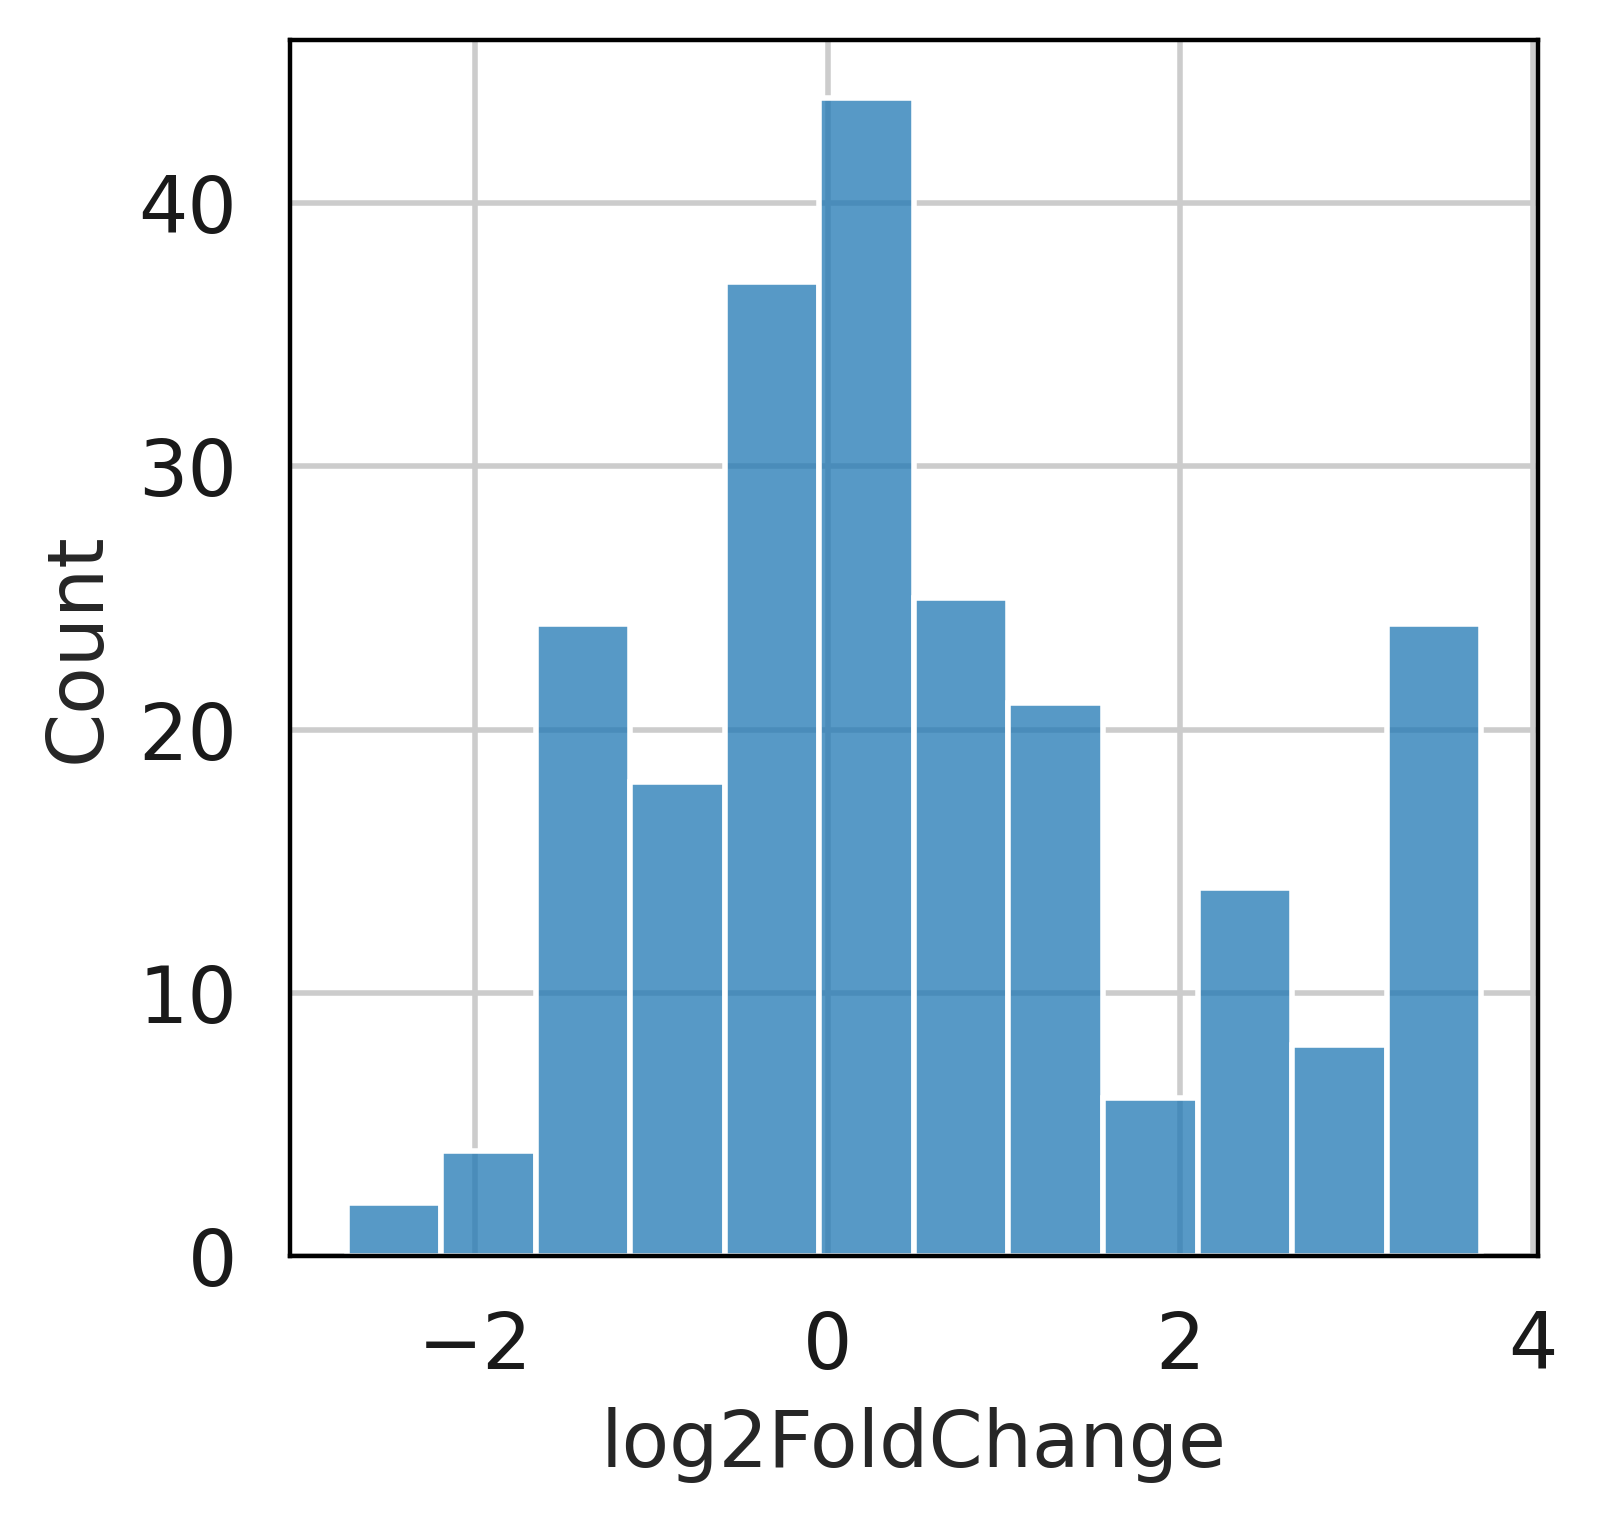

In [132]:
import seaborn as sns

sns.histplot(unique_res_df, x="log2FoldChange")

In [54]:
de_genes_mode = "ligand"
pvalue_col = "pvalue"
fc_col = "log2FoldChange"
gene_symbol_col = "gene_id"
max_pvalue = 0.1
min_abs_fc = 1
adjust_fdr = True
min_frac_expressed = 0.1

if de_genes_mode == "ligand":
    cpdb_de_col = "source_genesymbol"
    cpdb_expr_col = "target_genesymbol"
elif de_genes_mode == "receptor":
    cpdb_de_col = "target_genesymbol"
    cpdb_expr_col = "source_genesymbol"
else:
    raise ValueError("Invalud value for de_genes_mode!")

de_res = de_res.loc[lambda x: x[gene_symbol_col].isin(cpdba.cpdb[cpdb_de_col])]
if adjust_fdr:
    de_res = fdr_correction(de_res, pvalue_col=pvalue_col, key_added="fdr")
    pvalue_col = "fdr"

significant_genes = de_res.loc[
    lambda x: (x[pvalue_col] < max_pvalue) & (np.abs(x[fc_col]) >= min_abs_fc),
    gene_symbol_col,
].unique()  # type: ignore
significant_interactions = cpdba.cpdb.loc[
    lambda x: x[cpdb_de_col].isin(significant_genes)
]

res_df = (
    cpdba.expressed_genes.loc[
        lambda x: x["fraction_expressed"] >= min_frac_expressed
    ]  # type: ignore
    .merge(
        significant_interactions,
        left_on="variable",
        right_on=cpdb_expr_col,
    )
    .drop(columns=["variable"])
    .merge(de_res, left_on=cpdb_de_col, right_on=gene_symbol_col)
    .drop(columns=[gene_symbol_col])
)

In [ ]:
# cpdb_sig_int.to_csv(f"{resDir}/epithelial_cancer.csv")

In [63]:
res_df.to_csv(f"{resDir}/epithelial_cancer_updated.csv")

In [61]:
resDir

'/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/h5ads/'

## 07. Cell-cell interactions heatmap 

In [ ]:
immune_cells = [
    "Cancer cell",
    "B cell",
    "Endothelial",
    "DC mature",
    "Macrophage",
    "Mast cell",
    "Monocyte",
    "NK",
    "Neutrophil",
    "Plasma cell",
    "T cell CD4",
    "T cell CD8",
    "T cell regulatory",
    "cDC",
    "pDC",
]

In [ ]:
cpdb_sig_int = cpdb_sig_int.loc[lambda x: x["cell_type_fine"].isin(immune_cells)]

In [ ]:
top_genes = (
    cpdb_sig_int.loc[:, ["source_genesymbol", "fdr"]]
    .drop_duplicates()
    .sort_values("fdr")["source_genesymbol"][:30]
    .tolist()
)

In [ ]:
title_plot = f"{perturbation} vs {baseline}: {cell_type_oi}, FDR<0.1"

In [ ]:
save_name_plot = f"{perturbation}_vs_{baseline}_{cell_type_oi}_fdr_0.1"

In [ ]:
heatmap = cpdba.plot_result(
    cpdb_sig_int.loc[lambda x: x["source_genesymbol"].isin(top_genes)],
    title=title_plot,
    aggregate=False,
    cluster="heatmap",
    label_limit=110,
)
heatmap

In [ ]:
heatmap.save(f"{resDir}/figures/{save_name_plot}.png")
heatmap.save(f"{resDir}/figures/{save_name_plot}.svg")
heatmap.save(f"{resDir}/figures/{save_name_plot}.pdf")